# Testing the performance of the shape difference calculation and rotation calculation
## Concerns
* Need to assign confidence to angle, so that when the angle is ambiguous it is possible to flag it as such
* Need to determine the uncertainty of the minimum shape difference, and test whether it is a function of any of the floe parameters
* Need to make figures showing how the uncertainty is determined for use in the paper
* Test "floes": rectangle pairs, where SD is known and constant. 

In [1]:
using Pkg
Pkg.activate("calval")
# Pkg.add(["IceFloeTracker", "DataFrames", "Images", "ImageSegmentation", "CSV"])
# Pkg.add(["Plots", "Makie", "CairoMakie"])

  Activating new project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval`


In [4]:
using IceFloeTracker

[ Info: Precompiling IceFloeTracker [04643c7a-9ac6-48c5-822f-2704f9e70bd3] (cache misses: wrong dep version loaded (4), mismatched flags (14))


In [13]:
using Plots
using Images

In [ ]:
Pkg.instantiate()

# Rectangle test case


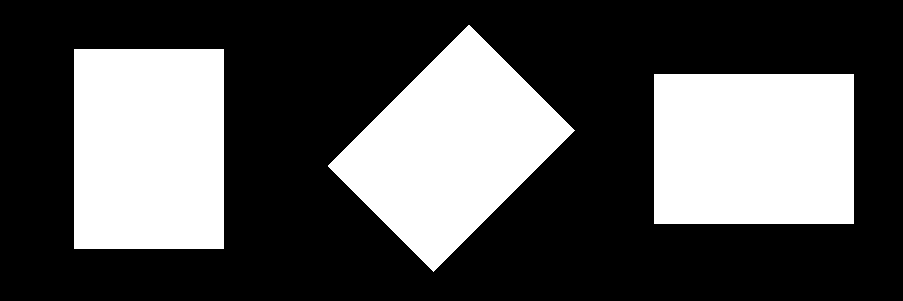

In [103]:
ll, hh = (301, 301)
R0 = falses((ll, hh))
L = 200
H = 150
cl = 150
ch = 150
R0[Int64(cl - L/2):Int64(cl + L/2 -1), Int64(ch - H/2):Int64(ch + H/2-1)] .= true
R90 = IceFloeTracker.imrotate_bin_clockwise_degrees(R0, 90)
R45 = IceFloeTracker.imrotate_bin_clockwise_degrees(R0, 45)
Images.mosaicview(Gray.(R0), Gray.(R45), Gray.(R90), nrow=1)

In [104]:
sum(R0), sum(R90), sum(R45)

(30000, 30000, 29998)

In [105]:
IceFloeTracker.matchcorr(R0, R90, 10.)

(mm = 0.0, c = 0.9815133436654654)

The register function works well:

In [106]:
rad2deg(IceFloeTracker.register(R0, R90)), rad2deg(IceFloeTracker.register(R0, R45))

(90.0, 45.0)

In [165]:
test_angles = deg2rad.(0:5:135)
sd = IceFloeTracker.shape_difference_rotation(R0, R90, test_angles);
angles = [x.angle for x in sd]
shape_diffs = [x.shape_difference for x in sd];

In [166]:
function mismatch_temp(fixed::AbstractArray, moving::AbstractArray, test_angles::AbstractArray)
    shape_differences = IceFloeTracker.shape_difference_rotation(
        fixed, moving, test_angles; imrotate_function=IceFloeTracker.imrotate_bin_clockwise_degrees
    )
    best_match = argmin((x) -> x.shape_difference, shape_differences)
    rotation_degrees = best_match.angle
    normalized_area = (sum(fixed) + sum(moving)) / 2
    normalized_mismatch = best_match.shape_difference / normalized_area
    return (mm=normalized_mismatch, rot=rotation_degrees, sd=best_match.shape_difference)
end
mismatch_temp(R0, R90, rad2deg.(test_angles))

(mm = 0.0, rot = 90.0, sd = 0.0)

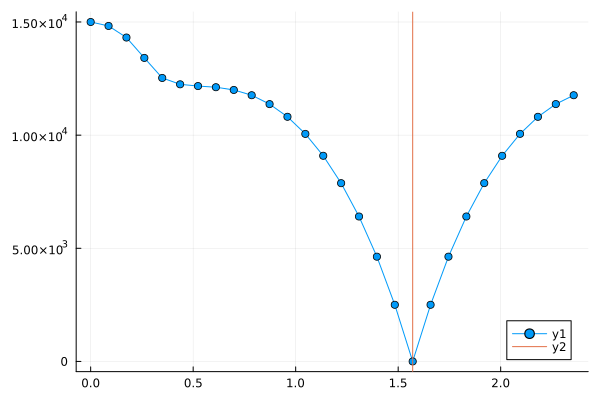

In [167]:
plot(angles, shape_diffs, marker=:circle)
vline!([deg2rad(90)])

For the rectangle case, and a simple 90 degree rotation, there shouldn't be any interpolation, and the shape difference minimum is 0. To look at the effect of the spline interpolation for intermediate rotations, we calculate the minimum shape difference for intermediate angles.

In [110]:
test_angles = 0:1:90
sd_test(a) = begin
    Rtheta = IceFloeTracker.imrotate_bin_clockwise_degrees(R0, a)
    mm, rot = mismatch_temp(R0, Rtheta, -45:1:135)
    mm
end

minimum_shape_difference = sd_test.(test_angles);

91-element Vector{Float64}:
 0.0
 6.666555557407377e-5
 0.0004000133337777926
 0.00023332166724997084
 0.0003999866671110963
 0.0005000083334722246
 0.0004999833338888704
 0.0005999900001666639
 0.0006333333333333333
 0.0005999900001666639
 0.0009000150002500041
 0.0008666666666666666
 0.0011666666666666668
 ⋮
 0.000866652222462959
 0.0008999850002499958
 0.0005999900001666639
 0.0006333227779537008
 0.0005999800006666444
 0.0005333155561481284
 0.0005000083334722246
 0.0003999866671110963
 0.00023332166724997084
 0.0004000133337777926
 6.666555557407377e-5
 0.0

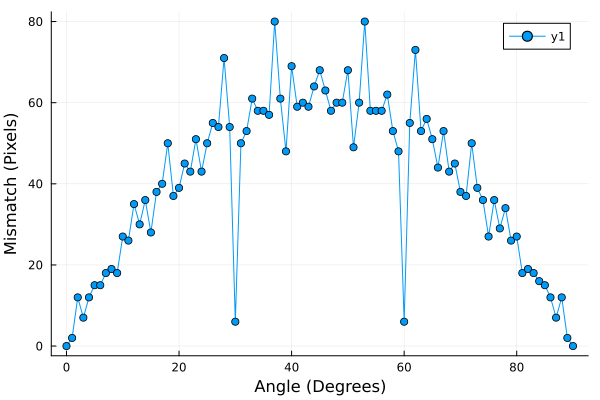

In [111]:
# Multiply by L*H since mismatch_temp returns SD / mean(area1, area2)
plot(test_angles, minimum_shape_difference .* L*H, ylabel="Mismatch (Pixels)", xlabel="Angle (Degrees)", marker=:circle)

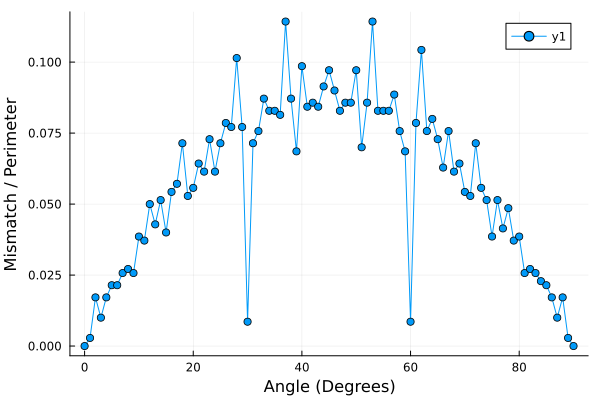

In [114]:
plot(test_angles, minimum_shape_difference .* L*H / (2*(L + H)), ylabel="Mismatch / Perimeter", xlabel="Angle (Degrees)", marker=:circle)

# Results
For the rectangle with dimensions 50 by 100 (equiv to a 18 km length scale floe), the absolute SD error ranges from 0 to 40 pixels. It is clearly a function of angle, with a maximum at 45 degrees and minimuma at 0 and 90. If we consider the perimeter to be the correct reference point, since the errors are likely to accumulate along the boundary, this means that the mismatch error maximum is about 5-10 percent. This held true whilst changing the rectangle size to 150 by 200.

## Floes from test directory

In [118]:
path = "/Users/dwatkin2/Documents/research/packages/IceFloeTracker.jl/test/test_inputs/tracker/"
floes =
            deserialize.([
                joinpath(path, f) for f in ["f1.dat", "f2.dat", "f3.dat", "f4.dat"]
            ])

4-element Vector{Matrix{Bool}}:
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
 [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]

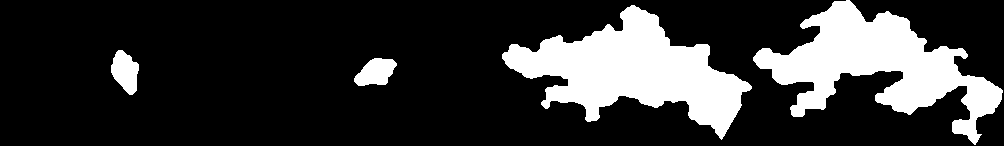

In [119]:
Images.mosaicview([Gray.(x) for x in floes], nrow=1)

In [183]:
test_angles = 0:1:179
sd_test(a) = begin
    ftheta = IceFloeTracker.imrotate_bin_nocrop(floes[2], deg2rad(a))
    f1, f2 = IceFloeTracker.align_centroids(floes[2], ftheta)
    mm, rot, sd = mismatch_temp(floes[1], ftheta, test_angles)
    return sd
end
minimum_shape_difference = sd_test.(test_angles);

In [191]:
test_angles = 0:1:179
rot_test(a) = begin
    ftheta = IceFloeTracker.imrotate_bin_nocrop(floes[2], deg2rad(a))
    f1, f2 = IceFloeTracker.align_centroids(floes[2], ftheta)
    mm, rot, sd = mismatch_temp(floes[2], ftheta, test_angles)
    return rot
end
rotation_accuracy = rot_test.(test_angles);

In [193]:
tab = IceFloeTracker.regionprops_table(label_components(floes[1]), properties=["area", "perimeter"])

Row,area,perimeter
,Float64,Float64
1,841.0,117.397


In the above experiment, the angle in the $x$ axis is the starting angle, and the Mismatch / Perimeter is the minimum value after the optimal rotation. Why is there a peak at 90 degrees? Does the function find the correct angle?

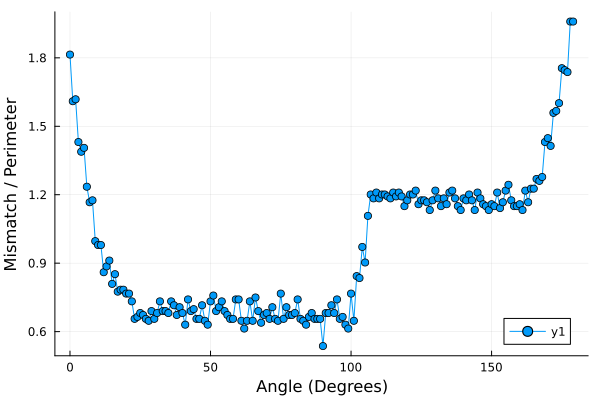

In [194]:
plot(test_angles, minimum_shape_difference / tab.perimeter, ylabel="Mismatch / Perimeter", xlabel="Angle (Degrees)", marker=:circle)

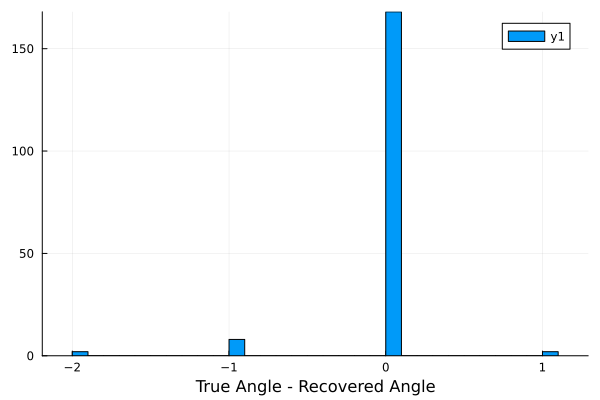

In [196]:
histogram(test_angles, rotation_accuracy .- test_angles, bins=30, xlabel="True Angle - Recovered Angle")

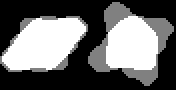

In [201]:
ftheta = IceFloeTracker.imrotate_bin_nocrop(floes[2], deg2rad(180))
f1, f2 = IceFloeTracker.align_centroids(floes[2], ftheta)
ftheta2 = IceFloeTracker.imrotate_bin_nocrop(floes[2], deg2rad(90))
f1a, f3 = IceFloeTracker.align_centroids(floes[2], ftheta2)
Images.mosaicview(0.5 .* Gray.(f1) .+ 0.5 .* Gray.(f2), 
    0.5 .* Gray.(f1a) .+ 0.5 .* Gray.(f3),
    nrow=1)

In [208]:
test_angles = deg2rad.(0:1:135)
sd = IceFloeTracker.shape_difference_rotation(f1a, f3, test_angles);
angles = [x.angle for x in sd]
shape_diffs = [x.shape_difference for x in sd];

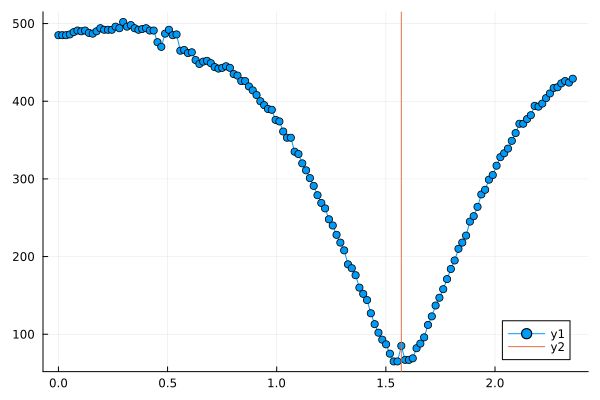

In [209]:
plot(angles, shape_diffs, marker=:circle)
vline!([deg2rad(90)])